In [1]:
import qualified Control.Monad.Bayes.Sampler.Lazy as Lazy
import qualified Control.Monad.Bayes.Inference.Lazy.MH as Lazy
import qualified Control.Monad.Bayes.Inference.Lazy.WIS as Lazy

import Control.Monad.Bayes.Class
import qualified Data.Text as T
import Numeric.Log
import Control.Arrow (first, second)
import Statistics.Distribution
import qualified Statistics.Distribution.Poisson as S
import Control.Monad.Bayes.Enumerator

:l ../Plotting.hs

# Lazy Sampling

The sampler defined in `Control.Monad.Bayes.Sampler.Strict` fares poorly with infinite data structures. For example, `finiteList` defined below is a distribution over a small finite set, but because it is defined as the marginal of an infinite list, running it with a strict sampling monad will not terminate.

In [2]:
finiteList :: MonadSample m => m [Double]
finiteList = do
    infiniteList <- sequence $ repeat random
    return (take 3 infiniteList)

One solution is to use a streaming library, such as `pipes`, and indeed this proves useful in many situations. But another is to define a lazy sampler, which is the approach taken by [LazyPPL](https://lazyppl.bitbucket.io/). 

In [3]:
Lazy.sampler finiteList

[0.30578459070444675,0.9581362978563391,0.961507459252835]

`Control.Monad.Bayes.Sampler.Lazy` is simply a port of LazyPPL, with some refactoring. In particular, what LazyPPL calls the `Prob` monad, we now call `Sampler`, and `Meas` is built modularly as `Weighted Sampler`. 

LazyPPL also comes with a number of inference algorithms that make special use of the sampler's laziness, including weighted importance sampling and Metropolis-Hastings. Monad-Bayes has these also, as shown below:

In [4]:
model :: MonadInfer m => m Bool
model = do
  -- Prior belief: it is Sunday with prob. 1/7
  sunday <- bernoulli (1/7)
  -- I know the rates of buses on the different days:
  let rate = if sunday then 3 else 10 
  -- observe 4 buses
  factor $ Exp $ logProbability (S.poisson rate) 4
  -- score $ poissonPdf rate 4
  return sunday

In [5]:
xws <- Lazy.lwis 10000 model

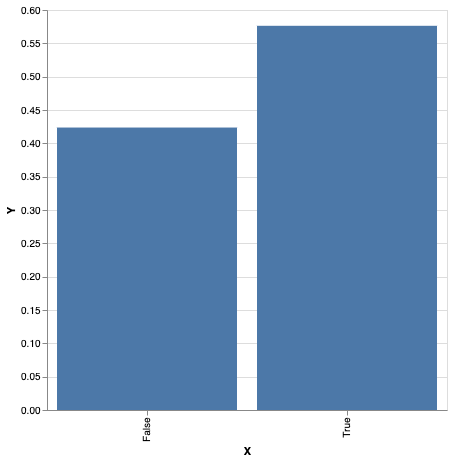

In [6]:
plot $ first (T.pack . show) <$> toEmpirical (take 10000 xws)

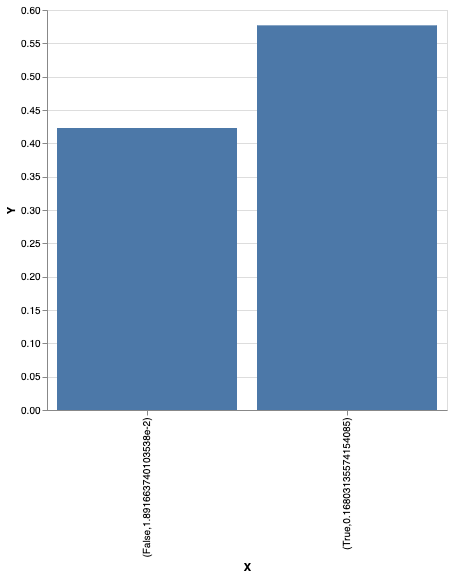

In [7]:
xws <- Lazy.mh 0.5 model

plot $ first (T.pack . show) <$> toEmpirical (take 10000 xws)